# Bookkeeping
## Data quality checks
- naming convention
- completeness
- image dimensions


Each case needs to have the following for both Aqua and Terra
- modis truecolor
- modis falsecolor
- modis cloudfraction
- modis landmask

They're stored in the `data/modis` folder. There should be a file for each case and for each satellite.

## TBD
- Add step to check whether the image dimensions are correct.

In [44]:
import pandas as pd
import numpy as np
import os
import pyproj 

overview_table = pd.read_csv('../data/validation_dataset/validation_dataset.csv', parse_dates=['start_date'])
overview_table['case_number'] = [str(x).zfill(3) for x in overview_table['case_number']]
overview_table.index = [cn + '_' + sat for cn, sat in zip(overview_table['case_number'], overview_table['satellite'])]
overview_table.head()

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,floe_obscuration,landfast_obscuration,modis_cloud_error,notes
001_terra,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.0,0.573,...,yes,daniel,emma,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
001_aqua,001,baffin_bay,2022-09-11,-91.527525,77.801013,-962500,-912500,9,1.0,0.573,...,yes,ethan,daniel,daniel,NaN,yes,heavy,NaN,no,reclassified landfast ice (likely cloud deck)
002_terra,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.0,0.858,...,no,daniel,emma,NaN,NaN,NaN,NaN,NaN,no,NaN
002_aqua,002,baffin_bay,2015-03-12,-81.964289,76.057935,-912500,-1212500,3,1.0,0.858,...,no,ethan,daniel,NaN,NaN,NaN,NaN,NaN,no,NaN
003_terra,003,baffin_bay,2012-04-19,-79.579288,75.637235,-887500,-1287500,4,1.0,0.873,...,yes,daniel,emma,NaN,NaN,NaN,NaN,heavy,no,NaN


## MODIS

In [16]:
for imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask']:
    for satellite in ['aqua', 'terra']:
        for case, data in overview_table.iterrows():
            fpath = os.path.join('../data/modis/', imtype, 
                              '-'.join([data.case_number,
                                        data.region,
                                        '100km',
                                        data.start_date.strftime('%Y%m%d')]) + '.' + \
                              '.'.join([satellite, imtype, '250m', 'tiff']))
            if not os.path.exists(fpath):
                print(fpath)

## MASIE

In [17]:
for imtype in 'seaice', 'landmask':
    for case, data in overview_table.iterrows():
        fpath = os.path.join('../data/masie/', imtype, 
                          '-'.join([data.case_number,
                                    data.region,
                                    '100km',
                                    data.start_date.strftime('%Y%m%d')]) + '.' + \
                          '.'.join(['masie', imtype, '250m', 'tiff']))
        if not os.path.exists(fpath):
            print(fpath)

# Checking the status of the validation imagery
Validation imagery comes in multiple categories: manually labeled and algorithmic labels. In the former category, we are checking the floe labeling column against the files found in the `binary_floes`, `binary_landmask`, `binary_landfast`, and `labeled_floes` subfolders.

First, we look to see if any images are listed in the data table that are missing from the folder.

If nothing prints, then all the images listed in the table are present.

In [45]:
dataloc = '../data/validation_dataset/'
tbd = []
for row, case in overview_table.iterrows():
    cn = str(case.case_number).zfill(3)
    region = case.region
    start = case.start_date
    satellite = case.satellite

    imtype = 'binary_floes'
    ftype = 'png'
    

    if case.visible_floes == 'yes':
        missing = []
        for imtype in ['binary_floes', 'binary_landfast', 'binary_landmask']:
            fpath = dataloc + imtype + '/' + \
                '-'.join([cn, region, start.strftime('%Y%m%d'), satellite, imtype]) + '.' + ftype
            if case.notnull().fl_analyst:
                if not os.path.isfile(fpath):
                    missing.append(imtype)
            elif imtype == 'binary_floes': # just tabulate the missing ones for binary floes
                tbd.append(row)
        if len(missing) > 0:
            print(cn, satellite, region, ' '.join(missing), case.fl_analyst)

print(len(missing))

0


In [46]:
print(len(tbd))

60


Next, check if any files in the folder aren't in the table.

Labeled floes:

In [36]:
files = [f for f in os.listdir(dataloc + 'labeled_floes') if 'tiff' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region)) & 
                            (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

Labeled landfast:

In [38]:
files = [f for f in os.listdir(dataloc + 'binary_landfast') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region)) & (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row.isnull()['fl_analyst'].values[0]:
            print(file)
    else:
        print(file, 'Missing from table')

Landmask: These are the cases that haven't had the validation images done yet. Landmask is done automatically so there are more files here than in the other categories.

In [47]:
files = [f for f in os.listdir(dataloc + 'binary_landmask') if 'png' in f]
files.sort()
for file in files:
    cn, region, date, satellite, suffix = file.split('-')
    row = overview_table.loc[((overview_table.case_number == cn) & (overview_table.region == region))
                                & (overview_table.satellite == satellite)]
    if len(row) > 0:
        if row['visible_floes'].values == 'yes':
            if row.isnull()['fl_analyst'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

025-barents_kara_seas-20090302-aqua-binary_landmask.png
025-barents_kara_seas-20090302-terra-binary_landmask.png
032-barents_kara_seas-20140501-aqua-binary_landmask.png
032-barents_kara_seas-20140501-terra-binary_landmask.png
034-barents_kara_seas-20200710-aqua-binary_landmask.png
034-barents_kara_seas-20200710-terra-binary_landmask.png
037-barents_kara_seas-20070326-aqua-binary_landmask.png
037-barents_kara_seas-20070326-terra-binary_landmask.png
039-barents_kara_seas-20170526-aqua-binary_landmask.png
039-barents_kara_seas-20170526-terra-binary_landmask.png
064-bering_chukchi_seas-20150716-aqua-binary_landmask.png
064-bering_chukchi_seas-20150716-terra-binary_landmask.png
070-bering_chukchi_seas-20120607-terra-binary_landmask.png
073-bering_chukchi_seas-20120513-aqua-binary_landmask.png
073-bering_chukchi_seas-20120513-terra-binary_landmask.png
079-bering_chukchi_seas-20110614-aqua-binary_landmask.png
079-bering_chukchi_seas-20110614-terra-binary_landmask.png
080-bering_chukchi_seas-2

Photoshop file:

In [46]:
files = [f for f in os.listdir(dataloc + 'labeling_psd_files/labeling_done') if 'psd' in f]
files.sort()
for file in files:
    cn = file.split('-')[0]
    if 'aqua' in file:
        satellite == 'aqua'
    else:
        satellite == 'terra'
    
    row = case_df.loc[(case_df.case_number == cn) & (case_df.satellite == satellite)]
    if len(row) > 0:
        if row.notnull()['fl_analyst'].values[0]:
            if row.isnull()['psd_file'].values[0]:
                print(file)
    else:
        print(file, 'Missing from table')

# TBD

Number of floes needing review, metadata needed, and metadata review needed

In [48]:
print('Metadata needed:', len(overview_table.loc[overview_table.qa_analyst.isnull()]))
print('Metadata review needed:', len(overview_table.loc[overview_table.qa_analyst.notnull()
                                     & overview_table.qa_reviewer.isnull()]))

print('Total images w/ floes:', len(overview_table.loc[(overview_table.visible_floes == 'yes'),:]))
print('Total labeled images:', len(overview_table.loc[(overview_table.visible_floes == 'yes')
                                   & overview_table.fl_analyst.notnull(),:]))
print('Images remaining:', len(overview_table.loc[((overview_table.visible_floes == 'yes')) 
                               & (overview_table.fl_analyst.isnull()),:]))
print('Floe labeling review needed:', len(overview_table.loc[overview_table.fl_analyst.notnull()
                                          & overview_table.fl_reviewer.isnull()]))

Metadata needed: 0
Metadata review needed: 0
Total images w/ floes: 228
Total labeled images: 168
Images remaining: 60
Floe labeling review needed: 140


Remaining images to process by region:

In [49]:
overview_table.loc[(((overview_table.visible_floes == 'yes')) & (overview_table.fl_analyst.isnull())),
['case_number', 'region']].groupby('region').count()

,case_number
region,
barents_kara_seas,10
bering_chukchi_seas,13
east_siberian_sea,12
greenland_sea,9
hudson_bay,16


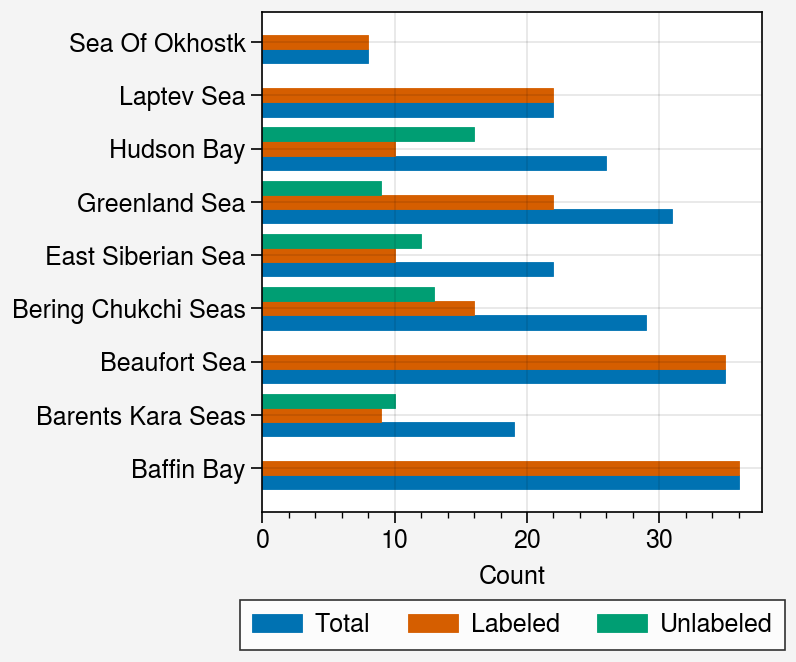

In [51]:
import proplot as pplt
data = overview_table.copy()
total_to_label = data.loc[data.visible_floes == 'yes'].groupby('region').count()['case_number']
total_labeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.notnull(),:].groupby('region').count()['case_number']
total_unlabeled = data.loc[(data.visible_floes == 'yes') & data.fl_analyst.isnull(),:].groupby('region').count()['case_number']
df = pd.DataFrame({'Total': total_to_label, 'Labeled': total_labeled, 'Unlabeled': total_unlabeled})
df.index = [x.replace('_', ' ').title() for x in df.index]
fig, ax = pplt.subplots()
ax.barh(df)
ax.format(xlabel='Count')
ax.legend(loc='b')
fig.save('../figures/labeling_progress_chart.png', dpi=300)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


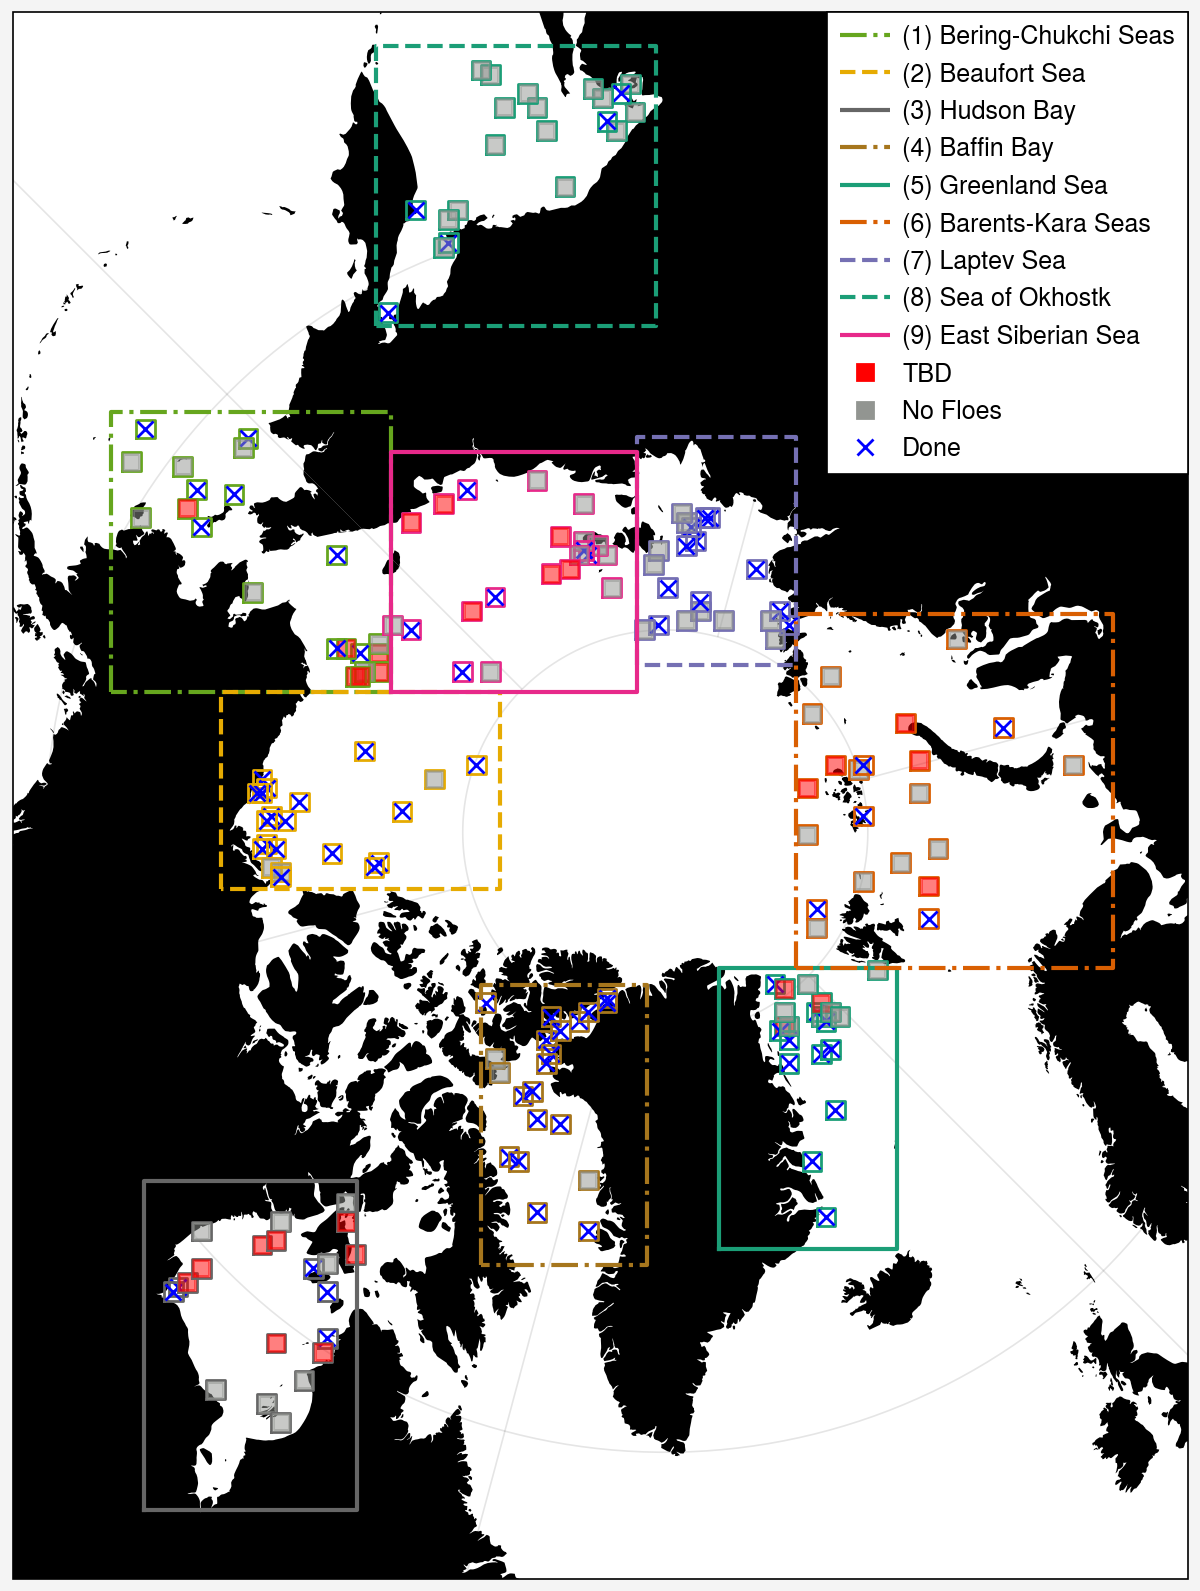

In [59]:
import proplot as pplt
import cartopy.crs as ccrs

df = pd.read_csv('../data/validation_dataset/validation_dataset.csv')
df = df.loc[df.satellite=='aqua']
df.index = [str(x).zfill(3) for x in df.case_number]

regions = pd.read_csv('../data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
linestyles = {region: ls for region, ls in zip(regions.index,
                        ['-', '-.', '--', '-', '-.', '--', '-.', '-', '--'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')

for idx, row in regions.iterrows():
    if row.print_title == 'Barents Kara Seas':
        regions.loc[idx, 'print_title'] = 'Barents-Kara Seas'
    if row.print_title == 'Bering Chukchi Seas':
        regions.loc[idx, 'print_title'] = 'Bering-Chukchi Seas'

pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, ax = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
ax.format(land=True, landzorder=0)

validated_cases = df.loc[df.fl_analyst.notnull()]
needs_validation = df.loc[df.fl_analyst.isnull() & (df.visible_floes == 'yes')]

no_floes_cases = df.loc[df.visible_floes == 'no']

for idx, region, lat, lon in zip(range(len(regions)), regions.index, regions.center_lat, regions.center_lon):

    xbox = np.array(regions.loc[region, ['left_x', 'left_x', 'right_x', 'right_x', 'left_x']].astype(float))
    ybox = np.array(regions.loc[region, ['lower_y', 'upper_y', 'upper_y', 'lower_y', 'lower_y']].astype(float))
    
    ax.plot(xbox, ybox, transform=ccrs.CRS('epsg:3413'),
            label='({n}) {t}'.format(n=idx + 1, t=regions.loc[region, 'print_title']), 
               color=colors[region], ls=linestyles[region], m='', zorder=5, lw=1.5)
    
ax.set_extent([-3.5e6, 2.8e6, -4e6, 4.4e6], crs=crs)
for idx, case in df.iterrows():
    x0 = case.center_x
    y0 = case.center_y
    left = x0 - 50e3
    right = x0 + 50e3
    bottom = y0 - 50e3
    top = y0 + 50e3 
    region = case.region

    ax.plot([left, left, right, right, left],
        [bottom, top, top, bottom, bottom], label='',
            transform=crs, color=colors[region], lw=1)
    if str(case.case_number).zfill(3) in validated_cases.index:
        ax.plot(x0, y0, m='x', color='b', transform=crs, label='')
    elif str(case.case_number).zfill(3) in no_floes_cases.index:
        ax.plot(x0, y0, m='s', color='gray', transform=crs, alpha=0.5, label='')
    elif str(case.case_number).zfill(3) in needs_validation.index:
        ax.plot(x0, y0, m='s', color='r', transform=crs, alpha=0.5, label='')        

ax.plot([],[],m='s', color='r', label='TBD', lw=0)
ax.plot([],[],m='s', color='gray', label='No Floes', lw=0)
ax.plot([],[],m='x', color='b', label='Done', lw=0)
ax.legend(ncols=1, alpha=1)

fig.save('../figures/progress_sampling_map.png', dpi=300)

In [56]:
overview_table.loc[((overview_table.region=='greenland_sea') & (overview_table.fl_analyst.isnull())) & (overview_table.visible_floes == 'yes')]

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,floe_obscuration,landfast_obscuration,modis_cloud_error,notes
106_aqua,106,greenland_sea,2014-09-11,-13.431029,78.793415,637500,-1037500,9,0.92,0.715,...,no,daniel,minki,NaN,NaN,NaN,moderate,NaN,NaN,NaN
106_terra,106,greenland_sea,2014-09-11,-13.431029,78.793415,637500,-1037500,9,0.92,0.715,...,no,daniel,minki,NaN,NaN,NaN,moderate,NaN,NaN,NaN
113_terra,113,greenland_sea,2014-08-10,-12.439562,78.672028,662500,-1037500,8,0.68,0.628,...,yes,daniel,minki,NaN,NaN,NaN,light,NaN,NaN,NaN
117_aqua,117,greenland_sea,2008-09-01,-7.721826,80.306085,637500,-837500,9,1.00,0.435,...,no,daniel,minki,NaN,NaN,NaN,moderate,NaN,NaN,NaN
117_terra,117,greenland_sea,2008-09-01,-7.721826,80.306085,637500,-837500,9,1.00,0.435,...,yes,daniel,minki,NaN,NaN,NaN,light,NaN,NaN,NaN
122_aqua,122,greenland_sea,2007-03-27,-2.454032,78.602599,837500,-912500,3,0.92,0.631,...,no,daniel,minki,NaN,NaN,NaN,heavy,NaN,NaN,NaN
122_terra,122,greenland_sea,2007-03-27,-2.454032,78.602599,837500,-912500,3,0.92,0.631,...,no,daniel,minki,NaN,NaN,NaN,moderate,NaN,NaN,NaN
124_terra,124,greenland_sea,2016-08-11,-1.818303,79.740399,762500,-812500,8,1.00,0.656,...,no,minki,ellen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125_terra,125,greenland_sea,2013-05-21,-1.487868,77.478383,937500,-987500,5,0.48,0.449,...,no,minki,ellen,NaN,NaN,NaN,light,NaN,NaN,NaN


# Summarizing the validation images
The floe size distribution and the total number of floes.

In [61]:
import pandas as pd
import rasterio as rio
from rasterio.plot import reshape_as_image
import skimage

# Load case data
df = pd.read_csv('../data/validation_dataset/validation_dataset.csv', parse_dates=['start_date'], index_col=0)

df['case_number'] = [str(cn).zfill(3) for cn in df.index]
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.tiff'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
        
# Load images
lb_dataloc = '../data/validation_dataset/labeled_floes/'
lb_images = {}

missing = []
for row, data in df.iterrows():
    if data.notnull().fl_analyst:
        with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
            lb_images[row] = im.read()[0, :,:]
            if lb_images[row].shape[0] != 400:
                print(row, lb_images[row].shape[0])

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [62]:
data = []
for row in lb_images:
    skimage.measure.regionprops_table(skimage.measure.label(lb_images[row]), properties=['area', 'label'])
    df = pd.DataFrame(skimage.measure.regionprops_table(
     skimage.measure.label(lb_images[row]),
     properties=['area', 'label']))
    df['case'] = row
    data.append(df)
data = pd.concat(data)

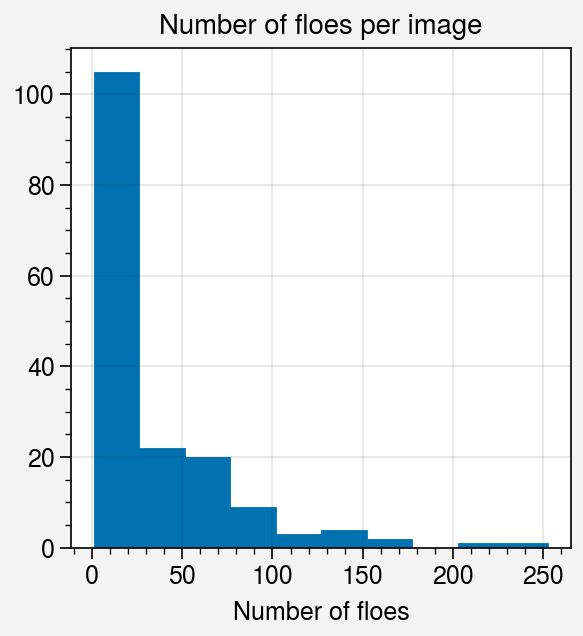

In [63]:
import proplot as pplt
fig, ax = pplt.subplots()
ax.hist(data.groupby('case').count()['area'])
ax.format(xlabel='Number of floes', title='Number of floes per image')

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


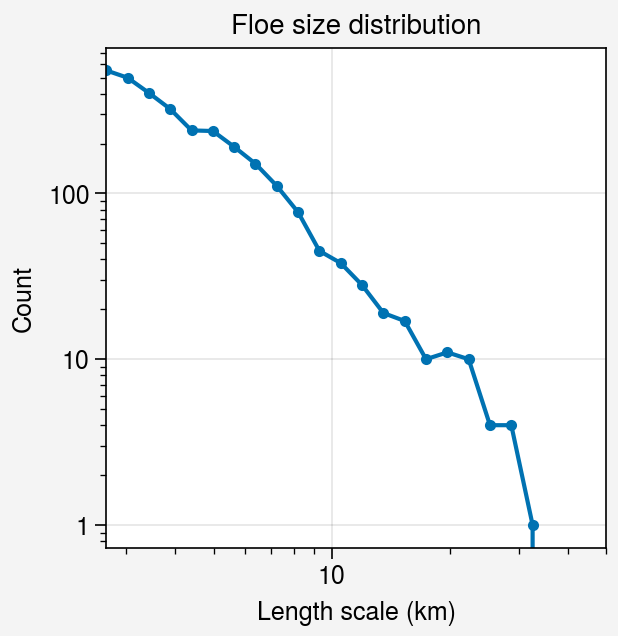

In [64]:
import numpy as np
fig, ax = pplt.subplots()

bins = np.logspace(1, np.log(np.sqrt(100)), 25)*0.25
x, xb = np.histogram(np.sqrt(data['area'])*0.25, bins)

ax.plot(0.5*(bins[:-1] + bins[1:]), x, marker='.')
ax.format(yscale='log', xscale='log', ylabel='Count',
          xlim=(0, 50), xlabel='Length scale (km)', title='Floe size distribution')

In [65]:
print('Total number of floes in ground truth data:', data.shape[0])
print('Median number of floes per image: ', data.groupby('case').count().median()['area'])

Total number of floes in ground truth data: 5594
Median number of floes per image:  15.0
